In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# standard libraries

import os, sys, logging, string, pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
# custom code
import opennem
import sim

# cache base dir to enable later cells to cd as needed (there might be a better way)
base_dir = os.getcwd() if not 'base_dir' in vars() else base_dir

In [2]:
sys.version

'3.6.3 |Anaconda, Inc.| (default, Nov  9 2017, 00:19:18) \n[GCC 7.2.0]'

In [3]:
# Get the data
start = datetime(2018,5,1)
end = datetime(2018,12,1)
# d2=datetime.today() - timedelta(days=7),
data = opennem.getdata(d1=start, d2=end, 
        regions = opennem.regions, # get all the regions
        data_dir = os.path.join(base_dir, 'opennemdata'),
        log_level = 'ERROR',
        )

data_dir: /home/jovyan/work/nem_sim/opennemdata
data_dir: /home/jovyan/work/nem_sim/opennemdata
getting 2018-05-01 00:00:00 2018-12-01 00:00:00 nsw1
got df_5, df_30 61632 10272 rows
getting 2018-05-01 00:00:00 2018-12-01 00:00:00 qld1
got df_5, df_30 61632 10272 rows
getting 2018-05-01 00:00:00 2018-12-01 00:00:00 sa1
got df_5, df_30 61632 10272 rows
getting 2018-05-01 00:00:00 2018-12-01 00:00:00 tas1
got df_5, df_30 61632 10272 rows
getting 2018-05-01 00:00:00 2018-12-01 00:00:00 vic1
got df_5, df_30 61632 10272 rows


In [15]:
# utilities and generic meta

# burning based generators
BURNING = ['BIOMASS', 'BLACK_COAL',
       'BROWN_COAL', 'DISTILLATE', 'GAS_CCGT', 'GAS_OCGT', 'GAS_RECIP',
       'GAS_STEAM']
       
def nice_state(region): # fix up OpenNEMPy's orrible keys
    return region[:-1].upper()

def plot(df, title, cols=False, ylabel = 'MW', figsize=(14,5), stacked=False):
    plt.figure()
    cols = cols if cols else df.keys()
    if stacked:
        df[cols].clip_lower(0).plot.area(title = title, figsize=figsize)
    else:
        df[cols].plot(title = title, figsize=figsize)
    plt.ylabel(ylabel)
    plt.show()

def junk():
    if stacked:
        for col in cols:
            df[col].clip_lower(0, axis=1, inplace=True)


# utility to visualise your data    
def plot_all(data):
    for state in opennem.regions: #
        df = data[state]
        # merge and drop the burning based generators
        df["BURNING"] = df[BURNING].sum(axis=1) 
        # df = df.drop(BURNING, axis=1)   
        # print(df.columns)
        cols = ['DEMAND', 'WIND', 'SOLAR', 'HYDRO', 'BURNING']
        cols = ['BURNING', 'WIND', 'SOLAR', 'HYDRO']
        plot(df = df, cols=cols, title = nice_state(state), stacked=True)
        cols = ['SOLAR', 'WIND']
        plot(df, cols=cols, title = nice_state(state), stacked=True)

# extract all from a single single source accross the country and scale up and down        
def all(data, col='WIND', regions='all', multiplier=False):
    frames = data.keys() if regions == 'all' else regions
    res = pd.concat(
        [data[region][col] for region in frames], 
        axis=1, 
        keys=frames)
    if multiplier:
        for region in frames:
          res[region] *= (multiplier[region] if multiplier else 1)
    return res

def multiplier_to_title(m=False):
    return ', '.join([f'{nice_state(state)}: x {float(x):.4}' for state, x in m.items()]) if m else 'Unadjusted'

# adjust a frame so that all cols have the same mean
def equalise(df, scale = False):
    means = df.mean()
    max_mean = scale if scale else means.max()
    multiplier = {}
    for region in df.columns:
        scale = max_mean/means[region]
        multiplier[region] = scale
        # print(f'scaling {region} by {scale} ({max_mean} / {means[region]})')
        df[region] *= max_mean / means[region]
    return df, multiplier

# run over a climbing series and express each value as a fraction of the previous peak
def flatten(df):
    for c in df.columns:
        m = 0
        for i, row in df.iterrows():
          m = max(row[c], m)
          val = row[c] / m if m else 0 # avoid division by 0
          df.at[i,c] = val
    return df

<Figure size 432x288 with 0 Axes>

               nsw1          qld1           sa1  tas1          vic1
count  61632.000000  61632.000000  61632.000000   0.0  61632.000000
mean     100.386401    100.386401    100.386401   NaN    100.386401
std      136.716988    144.306787    190.161772   NaN    185.595866
min        0.000000     -6.774171      0.000000   NaN    -58.068495
25%        0.190000      0.936521      0.000000   NaN      0.000000
50%        1.130000      2.434955      0.000000   NaN      0.000000
75%      208.775000    176.724172    109.694329   NaN    151.345367
max      522.150000    621.933393    674.724737   NaN   1180.430541


<Figure size 432x288 with 0 Axes>

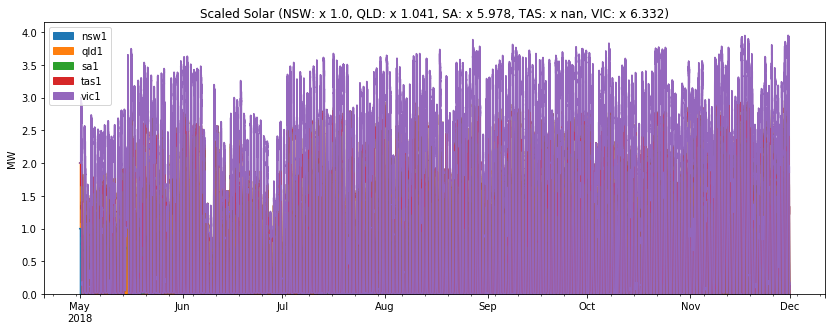

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

               nsw1          qld1           sa1          tas1          vic1
count  61632.000000  31680.000000  61632.000000  61632.000000  61632.000000
mean       0.416909      0.372601      0.427215      0.436114      0.401176
std        0.269217      0.336435      0.287128      0.312530      0.283930
min       -0.008709      0.000000     -0.005539     -0.005084     -0.005297
25%        0.185465      0.065233      0.155791      0.148229      0.153302
50%        0.374736      0.277985      0.401808      0.396396      0.344068
75%        0.635207      0.649168      0.724305      0.704399      0.635173
max        1.000000      1.000000      1.000000      1.000000      1.000000


<Figure size 432x288 with 0 Axes>

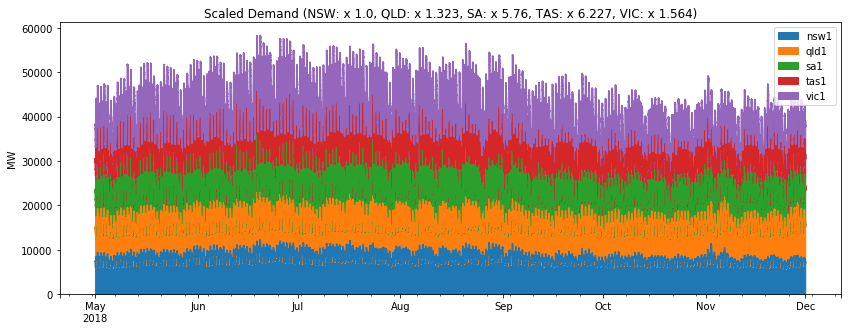

               nsw1          qld1           sa1          tas1          vic1
count  61632.000000  61632.000000  61632.000000  61632.000000  61632.000000
mean    8186.129651   8186.129651   8186.129651   8186.129651   8186.129651
std     1110.416709    954.553109   1633.719806    985.912572   1272.779636
min     5798.430000   6331.481644   3429.518626   5552.216772   5381.864145
25%     7408.857500   7380.989629   7094.782094   7429.940752   7181.584123
50%     8070.435000   8065.384928   8026.240643   8056.876253   8098.910003
75%     8840.460000   8878.400746   9195.921012   8899.603982   9092.109762
max    12256.660000  11900.685308  13781.554237  11226.924941  11860.992147


In [20]:
source = 'SOLAR'
solar, smultiplier = equalise(all(data, col=source))
plot(solar, title = f'Scaled {source.title()} ({multiplier_to_title(smultiplier)})',stacked = True)
print(solar.describe())
solar = flatten(solar)
plot(solar, title = f'Scaled {source.title()} ({multiplier_to_title(smultiplier)})', stacked=True)

source = 'WIND'
wind, wmultiplier = equalise(all(data, col=source))
plot(wind, title = f'Scaled {source.title()} ({multiplier_to_title(wmultiplier)})', stacked=True)
wind = flatten(wind)
plot(wind, title = f'Scaled {source.title()} ({multiplier_to_title(wmultiplier)})', stacked=True)
print(wind.describe())

source = 'DEMAND'
demand, dmultiplier = equalise(all(data, col=source))
plot(demand, title = f'Scaled {source.title()} ({multiplier_to_title(dmultiplier)})', stacked=True)
print(demand.describe())

<Figure size 432x288 with 0 Axes>

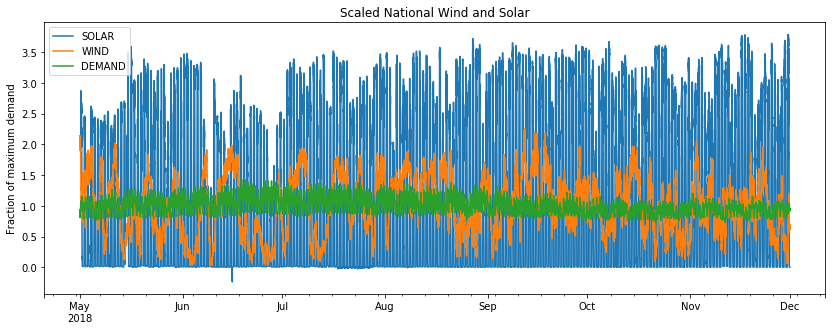

In [21]:
total_wind = wind.sum(axis=1)
total_solar = solar.sum(axis=1)
total_demand = demand.sum(axis=1)

total_wind.head()
type(total_solar)
scaled = pd.DataFrame()
scaled['SOLAR'] =total_solar
scaled['WIND'] = total_wind
scaled['DEMAND'] = total_demand
scaled, m = equalise(scaled, scale = 1)
plot(scaled, 'Scaled National Wind and Solar', ylabel="Fraction of maximum demand")

In [22]:
print(f'{scaled.index.min()} - {scaled.index.max()} ({scaled.index.max()-scaled.index.min()})')
scaled.describe()

2018-05-01 00:05:00 - 2018-12-01 00:00:00 (213 days 23:55:00)


SOLAR          WIND        DEMAND
count  61632.000000  61632.000000  61632.000000
mean       1.000000      1.000000      1.000000
std        1.240214      0.473884      0.128271
min       -0.236779      0.024198      0.735107
25%        0.004120      0.626402      0.899253
50%        0.017949      0.993698      0.985953
75%        2.230947      1.370158      1.079072
max        3.784876      2.252641      1.424917

In [62]:
def scenarios(
    mix_step = 0.25, 
    max_vre = 2, 
    min_vre = 1, 
    vre_step = 0.1,
    storage = [1, 1.25, 1.5, 1.75, 2], # [0,0.25, 1, 2, 4]
    ):
    vre_steps = int((max_vre - min_vre) / vre_step) + 1
    for storage_size in storage:
        for vre_increment in range(vre_steps):
            vre_fraction = vre_step * vre_increment + min_vre
            wind = 0 if vre_fraction else 1 # only run the 0 scenario once
            while wind <= 1:
                solar = 1-wind if vre_fraction else 0
                yield wind if vre_fraction else 0, solar, \
                    wind * vre_fraction, solar * vre_fraction, storage_size
                wind += mix_step
                
def plot_sim(df):
    if storage:
        plot(df = df, 
             cols=['BATTERY_CHARGE_RATE'], 
             title = f'Battery Charge - {title}', 
             ylabel='Fraction of average demand')
        plot(df = df, cols=['BATTERY_STATE'],
             title = f'Battery State - {title}', ylabel='Hours Storage')
    cols = ['DEMAND', 'SIM_SOLAR', 'SIM_WIND', 'BATTERY_CHARGE_RATE', 'DEFICIT'] # 'BALANCE']
    plot(df = df, cols=cols, title = title, ylabel='Fraction of average demand')
    

In [64]:
df = scaled 

In [ ]:
#df = scaled[0:400].copy()
results = []

In [65]:
for wind_fraction, solar_fraction, wind, solar, storage in scenarios():
    mix = f'{solar_fraction*100}% solar, {wind_fraction*100}% wind'
    build = wind+solar

    title = f'{100*(wind+solar)}% wind: {wind*100}%, solar: {solar*100}% with {storage} days storage'
    print(f'running {title}')
    sim_df = sim.run(df = df
             , wind = wind, solar = solar
             , title = title
             , max_battery = storage * 24
             , max_charge_mw = 1_000_000, max_discharge_mw = 1_000_000
             , log_level=
              #'DEBUG'
              'WARNING'
            )
    print(f'''
    max charge rate: {sim_df['BATTERY_CHARGE_RATE'].max():.2}
    total demand: {sim_df['DEMAND'].mean():.3}
    total deficit: {sim_df['DEFICIT'].mean():.3}
    vre: {(1 - (sim_df['DEFICIT'].mean()/sim_df['DEMAND'].mean()))*100:.4}%
         ''')
    result = {
        'mix': mix, 'build': build, 'wind': wind, 'solar': solar, 'storage': storage,
        'wind_fraction': wind/build if build else 0,
        'max_charge': sim_df['BATTERY_CHARGE_RATE'].max(),
        'vre': (1 - (sim_df['DEFICIT'].mean()/sim_df['DEMAND'].mean()))*100
    }
    results.append(result)
    # plot_sim(sim_df)
    
result_df = pd.DataFrame(results)

running 100.0% wind: 0.0%, solar: 100.0% with 1 days storage

    max charge rate: 3.0
    total demand: 1.0
    total deficit: 0.107
    vre: 89.26%
         
running 100.0% wind: 25.0%, solar: 75.0% with 1 days storage

    max charge rate: 2.3
    total demand: 1.0
    total deficit: 0.085
    vre: 91.5%
         
running 100.0% wind: 50.0%, solar: 50.0% with 1 days storage

    max charge rate: 1.9
    total demand: 1.0
    total deficit: 0.0758
    vre: 92.42%
         
running 100.0% wind: 75.0%, solar: 25.0% with 1 days storage

    max charge rate: 1.5
    total demand: 1.0
    total deficit: 0.085
    vre: 91.5%
         
running 100.0% wind: 100.0%, solar: 0.0% with 1 days storage

    max charge rate: 1.3
    total demand: 1.0
    total deficit: 0.114
    vre: 88.63%
         
running 110.00000000000001% wind: 0.0%, solar: 110.00000000000001% with 1 days storage

    max charge rate: 3.4
    total demand: 1.0
    total deficit: 0.0677
    vre: 93.23%
         
running 110.00


    max charge rate: 3.1
    total demand: 1.0
    total deficit: 0.00721
    vre: 99.28%
         
running 190.0% wind: 190.0%, solar: 0.0% with 1 days storage

    max charge rate: 3.2
    total demand: 1.0
    total deficit: 0.0253
    vre: 97.47%
         
running 200.0% wind: 0.0%, solar: 200.0% with 1 days storage

    max charge rate: 6.4
    total demand: 1.0
    total deficit: 0.00353
    vre: 99.65%
         
running 200.0% wind: 50.0%, solar: 150.0% with 1 days storage

    max charge rate: 4.9
    total demand: 1.0
    total deficit: 0.00327
    vre: 99.67%
         
running 200.0% wind: 100.0%, solar: 100.0% with 1 days storage

    max charge rate: 3.2
    total demand: 1.0
    total deficit: 0.00416
    vre: 99.58%
         
running 200.0% wind: 150.0%, solar: 50.0% with 1 days storage

    max charge rate: 3.3
    total demand: 1.0
    total deficit: 0.00605
    vre: 99.39%
         
running 200.0% wind: 200.0%, solar: 0.0% with 1 days storage

    max charge rate: 3.4


    max charge rate: 4.3
    total demand: 1.0
    total deficit: 0.00331
    vre: 99.67%
         
running 180.0% wind: 90.0%, solar: 90.0% with 1.25 days storage

    max charge rate: 3.0
    total demand: 1.0
    total deficit: 0.00456
    vre: 99.54%
         
running 180.0% wind: 135.0%, solar: 45.0% with 1.25 days storage

    max charge rate: 2.9
    total demand: 1.0
    total deficit: 0.00791
    vre: 99.21%
         
running 180.0% wind: 180.0%, solar: 0.0% with 1.25 days storage

    max charge rate: 3.0
    total demand: 1.0
    total deficit: 0.0252
    vre: 97.48%
         
running 190.0% wind: 0.0%, solar: 190.0% with 1.25 days storage

    max charge rate: 6.0
    total demand: 1.0
    total deficit: 0.00241
    vre: 99.76%
         
running 190.0% wind: 47.5%, solar: 142.49999999999997% with 1.25 days storage

    max charge rate: 4.6
    total demand: 1.0
    total deficit: 0.00267
    vre: 99.73%
         
running 190.0% wind: 95.0%, solar: 95.0% with 1.25 days stor


    max charge rate: 5.3
    total demand: 1.0
    total deficit: 0.00296
    vre: 99.7%
         
running 170.00000000000003% wind: 42.50000000000001%, solar: 127.50000000000001% with 1.5 days storage

    max charge rate: 4.1
    total demand: 1.0
    total deficit: 0.003
    vre: 99.7%
         
running 170.00000000000003% wind: 85.00000000000001%, solar: 85.00000000000001% with 1.5 days storage

    max charge rate: 3.0
    total demand: 1.0
    total deficit: 0.00417
    vre: 99.58%
         
running 170.00000000000003% wind: 127.50000000000001%, solar: 42.50000000000001% with 1.5 days storage

    max charge rate: 2.7
    total demand: 1.0
    total deficit: 0.00899
    vre: 99.1%
         
running 170.00000000000003% wind: 170.00000000000003%, solar: 0.0% with 1.5 days storage

    max charge rate: 2.8
    total demand: 1.0
    total deficit: 0.0253
    vre: 97.47%
         
running 180.0% wind: 0.0%, solar: 180.0% with 1.5 days storage

    max charge rate: 5.7
    total deman


    max charge rate: 2.3
    total demand: 1.0
    total deficit: 0.0128
    vre: 98.72%
         
running 150.0% wind: 150.0%, solar: 0.0% with 1.75 days storage

    max charge rate: 2.4
    total demand: 1.0
    total deficit: 0.0295
    vre: 97.05%
         
running 160.0% wind: 0.0%, solar: 160.0% with 1.75 days storage

    max charge rate: 5.0
    total demand: 1.0
    total deficit: 0.00265
    vre: 99.74%
         
running 160.0% wind: 40.0%, solar: 120.00000000000001% with 1.75 days storage

    max charge rate: 4.0
    total demand: 1.0
    total deficit: 0.00269
    vre: 99.73%
         
running 160.0% wind: 80.0%, solar: 80.0% with 1.75 days storage

    max charge rate: 2.9
    total demand: 1.0
    total deficit: 0.0056
    vre: 99.44%
         
running 160.0% wind: 120.00000000000001%, solar: 40.0% with 1.75 days storage

    max charge rate: 2.5
    total demand: 1.0
    total deficit: 0.0101
    vre: 98.99%
         
running 160.0% wind: 160.0%, solar: 0.0% with 1.75


    max charge rate: 3.5
    total demand: 1.0
    total deficit: 0.00718
    vre: 99.28%
         
running 140.0% wind: 70.0%, solar: 70.0% with 2 days storage

    max charge rate: 2.5
    total demand: 1.0
    total deficit: 0.0102
    vre: 98.98%
         
running 140.0% wind: 104.99999999999999%, solar: 35.0% with 2 days storage

    max charge rate: 2.1
    total demand: 1.0
    total deficit: 0.0138
    vre: 98.62%
         
running 140.0% wind: 140.0%, solar: 0.0% with 2 days storage

    max charge rate: 2.2
    total demand: 1.0
    total deficit: 0.0299
    vre: 97.01%
         
running 150.0% wind: 0.0%, solar: 150.0% with 2 days storage

    max charge rate: 4.7
    total demand: 1.0
    total deficit: 0.00526
    vre: 99.47%
         
running 150.0% wind: 37.5%, solar: 112.5% with 2 days storage

    max charge rate: 3.7
    total demand: 1.0
    total deficit: 0.00332
    vre: 99.67%
         
running 150.0% wind: 75.0%, solar: 75.0% with 2 days storage

    max charge 

In [66]:
result_df.describe()
result_df

build  max_charge                      mix  solar  storage         vre  \
0      0.0   -0.000000        0% solar, 0% wind  0.000      0.0    0.000000   
1      0.2   -0.000000      100% solar, 0% wind  0.200      0.0   20.000000   
2      0.2   -0.000000  75.0% solar, 25.0% wind  0.150      0.0   20.000000   
3      0.2   -0.000000  50.0% solar, 50.0% wind  0.100      0.0   20.000000   
4      0.2   -0.000000  25.0% solar, 75.0% wind  0.050      0.0   20.000000   
5      0.2   -0.000000  0.0% solar, 100.0% wind  0.000      0.0   20.000000   
6      0.4   -0.000000      100% solar, 0% wind  0.400      0.0   34.879355   
7      0.4   -0.000000  75.0% solar, 25.0% wind  0.300      0.0   38.359069   
8      0.4   -0.000000  50.0% solar, 50.0% wind  0.200      0.0   39.838407   
9      0.4   -0.000000  25.0% solar, 75.0% wind  0.100      0.0   39.995117   
10     0.4   -0.000000  0.0% solar, 100.0% wind  0.000      0.0   39.997488   
11     0.6    0.000000      100% solar, 0% wind  0.600      0.0   39.586172   
12     0.6    0.000000  75.0% solar, 25.0% wind  0.450      0.0   47.637510   
13     0.6    0.000000  50.0% solar, 50.0% wind  0.300      0.0   54.655675   
14     0.6    0.000000  25.0% solar, 75.0% wind  0.150      0.0   58.518890   
15     0.6    0.000000  0.0% solar, 100.0% wind  0.000      0.0   58.919408   
16     0.8    0.000000      100% solar, 0% wind  0.800      0.0   41.679104   
17     0.8    0.000000  75.0% solar, 25.0% wind  0.600      0.0   53.001042   
18     0.8    0.000000  50.0% solar, 50.0% wind  0.400      0.0   63.913584   
19     0.8    0.000000  25.0% solar, 75.0% wind  0.200      0.0   72.028093   
20     0.8    0.000000  0.0% solar, 100.0% wind  0.000      0.0   71.977776   
21     1.0    0.000000      100% solar, 0% wind  1.000      0.0   42.933251   
22     1.0    0.000000  75.0% solar, 25.0% wind  0.750      0.0   57.231003   
23     1.0    0.000000  50.0% solar, 50.0% wind  0.500      0.0   71.113096   
24     1.0    0.000000  25.0% solar, 75.0% wind  0.250      0.0   80.585926   
25     1.0    0.000000  0.0% solar, 100.0% wind  0.000      0.0   79.666502   
26     1.2    0.000000      100% solar, 0% wind  1.200      0.0   43.776268   
27     1.2    0.000000  75.0% solar, 25.0% wind  0.900      0.0   60.959435   
28     1.2    0.000000  50.0% solar, 50.0% wind  0.600      0.0   77.055618   
29     1.2    0.000000  25.0% solar, 75.0% wind  0.300      0.0   85.828732   
..     ...         ...                      ...    ...      ...         ...   
750    1.5    4.705485      100% solar, 0% wind  1.500      2.0   99.474162   
751    1.5    3.715236  75.0% solar, 25.0% wind  1.125      2.0   99.668343   
752    1.5    2.760151  50.0% solar, 50.0% wind  0.750      2.0   99.295067   
753    1.5    2.288114  25.0% solar, 75.0% wind  0.375      2.0   98.882066   
754    1.5    2.368578  0.0% solar, 100.0% wind  0.000      2.0   97.398324   
755    1.6    4.980454      100% solar, 0% wind  1.600      2.0   99.851828   
756    1.6    3.982833  75.0% solar, 25.0% wind  1.200      2.0   99.847330   
757    1.6    2.937768  50.0% solar, 50.0% wind  0.800      2.0   99.556808   
758    1.6    2.495869  25.0% solar, 75.0% wind  0.400      2.0   99.108528   
759    1.6    2.581698  0.0% solar, 100.0% wind  0.000      2.0   97.786429   
760    1.7    5.304078      100% solar, 0% wind  1.700      2.0   99.937713   
761    1.7    4.141392  75.0% solar, 25.0% wind  1.275      2.0   99.933369   
762    1.7    3.027089  50.0% solar, 50.0% wind  0.850      2.0   99.816194   
763    1.7    2.703624  25.0% solar, 75.0% wind  0.425      2.0   99.334399   
764    1.7    2.794817  0.0% solar, 100.0% wind  0.000      2.0   98.170227   
765    1.8    5.664852      100% solar, 0% wind  1.800      2.0  100.000000   
766    1.8    4.342429  75.0% solar, 25.0% wind  1.350      2.0  100.000000   
767    1.8    3.206999  50.0% solar, 50.0% wind  0.900      2.0   99.894654   
768    1.8    2.911379  25.0% solar, 75.0% wind  0.450 

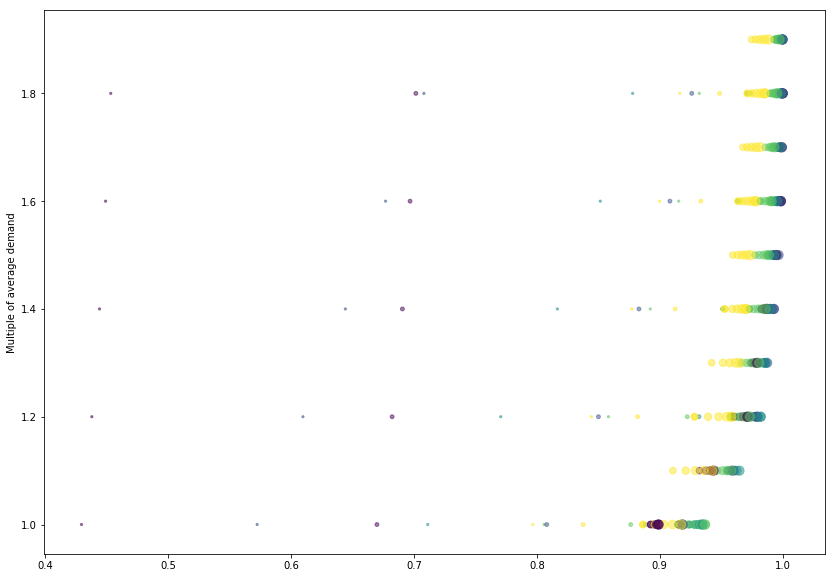

In [67]:
filter = 'build >= 1 and build < 2 and storage <= 2'
df = result_df.query(filter)
plt.figure(figsize=(14,10))
plt.scatter(df[['vre']]/100, df[['build']], 
            s=df[['storage']]*40+5,
            alpha = 0.5,
            c=df[['wind_fraction']])
plt.ylabel('Multiple of average demand')
#plt.xlabel('Percent Wind and Solar Renewable')
plt.show()   

In [68]:
mixes = set(result_df.query('build>0')['mix'])
mixes = sorted(mixes, key=lambda y: float(y.split('%')[0]))


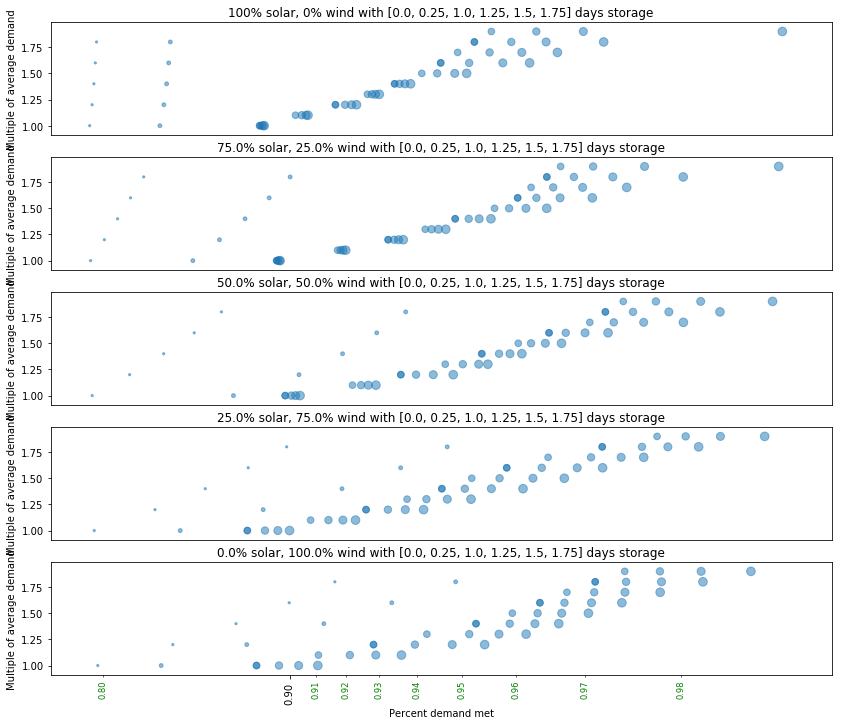

In [71]:
fig = plt.figure(figsize=(14,12))

i = 0
ax = []
for mix in mixes:
    df = result_df.query(f'mix == "{mix}" and build >= 1.0 and build < 2.0 and storage < 2')
    storage = sorted(set(df['storage']))
    ax.append(fig.add_subplot(len(mixes),1,len(mixes)-i, 
                              title=f'{mix} with {storage} days storage'))
    ax[i].set_xscale('logit')
    if i:
        plt.setp(ax[i].get_xticklabels(), visible=False)
        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off)

    plt.xticks(rotation=90)
    ax[i].set_ylabel("Multiple of average demand")
    ax[i].scatter(df[['vre']]/100-.0000001, # need to subtract small a trace or disapears :-/
                df[['build']], 
                s=df[['storage']]*40+5,
                alpha = 0.5,
                #c=result_df[['wind_fraction']]
           )
    i+=1
    
ax[0].set_xlabel('Percent demand met')
ax[0].spines['bottom']._adjust_location()
ax[0].tick_params(axis='x', which='minor', labelsize='small', labelcolor='g', rotation=90)

plt.show()

In [ ]:
# Explore some custom scalings
source = 'WIND'
multiplier = False
scaled = all(data, col=source)
plot(scaled, title = f'Scaled {source.title()} ({multiplier_to_title(multiplier)})', stacked=True)
print(scaled.describe())

multiplier = {'nsw1': 2, 'qld1': 40, 'sa1': 1, 'tas1': 2, 'vic1':1}
scaled = all(data, col=source, multiplier=multiplier)
plot(scaled, title = f'Scaled {source.title()} ({multiplier_to_title(multiplier)})', stacked=True)
print(scaled.head())

source = 'SOLAR'
multiplier = False
scaled = all(data, col=source)
plot(scaled, title = f'Scaled {source.title()} ({multiplier_to_title(multiplier)})', stacked=True)

In [ ]:
log = logging.getLogger()
log.addHandler(logging.StreamHandler(sys.stdout))

In [ ]:
# visualise all the data
plot_all(data)


In [ ]:
# Run a sim:
state ='vic1'
sim_df = sim.run(df = data[state]
             , wind = 5, solar =40
             , title = 'qld x5'
             , max_battery = 2_000_000
             , max_charge_mw = 1_000_000, max_discharge_mw = 1_000_000
             , log_level=
              #'DEBUG'
              'INFO'
            )    

cols = ['DEMAND', 'WIND', 'SOLAR', 'SIM_SOLAR', 'SIM_WIND']
plot(df = sim_df, cols=cols, title = nice_state(state))

In [ ]:
cols = ['BATTERY_CHARGE_RATE']
plot(df = sim_df, cols=cols, title = nice_state(state))
cols = ['BATTERY_STATE']
plot(df = sim_df, cols=cols, title = nice_state(state), ylabel='MWh')
cols = ['DEMAND', 'SIM_SOLAR', 'SIM_WIND', 'BATTERY_CHARGE_RATE', 'BALANCE']
plot(df = sim_df, cols=cols, title = nice_state(state))
cols = ['BALANCE']
plot(df = sim_df, cols=cols, title = nice_state(state))

In [ ]:
# explore the data
for state in opennem.regions:
    df = data[state]
    print(nice_state(state))
    print(df.index.min(), ' - ', df.index.max(), df.index.hasnans)
    print(df.keys())
    print(df.describe(include='all'))